# Example for integration with HyperSpy lazy signals

This notebook shows how to process a HyperSpy [lazy signal](http://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html) using LiberTEM, how to create a HyperSpy lazy signal from a LiberTEM DataSet, and how to create a lazy HyperSpy signal from a LiberTEM computation. It uses PyXem for scanning diffraction data support

This notebook requires the `hdbscan` extra. It is incompatible with `pyfftw` that is optionally used in `libertem-blobfinder` because of apparent thread safety issues.

Please note that these features are rather new and not well-tested yet. Bug reports and improvements are much appreciated!

In [1]:
%matplotlib nbagg

In [2]:
import os

import numpy as np
import hyperspy.api as hs
import pyxem
import matplotlib.pyplot as plt

# Modify some LiberTEM internals to pretend not having pyfftw
import libertem_blobfinder.base.correlation
libertem_blobfinder.base.correlation.fft = np.fft
libertem_blobfinder.base.correlation.zeros = np.zeros

import libertem.utils.threading
libertem.utils.threading.__has_pyfftw = False

from libertem.api import Context
from libertem.executor.delayed import DelayedJobExecutor
from libertem.udf.sumsigudf import SumSigUDF
from libertem.contrib.daskadapter import make_dask_array
from libertem_blobfinder.common import correlation, patterns
from libertem_blobfinder.udf import refinement
import libertem.analysis.fullmatch as fm

/Users/weber/.conda/envs/libertem37/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


In [3]:
# Use a LiberTEM executor that plays well with the curren Dask scheduler
ctx = Context.make_with("dask-integration")

# Alternatively, one could use the LiberTEM Dask scheduler as default Dask scheduler
# Unfortunately, the current BLO reader in Hyperspy doesn't play well with the distributed scheduler
# ctx = Context.make_with("dask-make-default")

In [4]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/cachedata/users/clausen/libertem-test-data/")
path = os.path.join(data_base_path, "default.blo")

## Load data as HyperSpy lazy signal

In [5]:
lazy_4d = hs.load(path, lazy=True)

In [6]:
lazy_4d

<LazyDiffraction2D, title: , dimensions: (121, 90|144, 144)>

In [7]:
type(lazy_4d.data)

dask.array.core.Array

[########################################] | 100% Completed |  0.4s


<IPython.core.display.Javascript object>


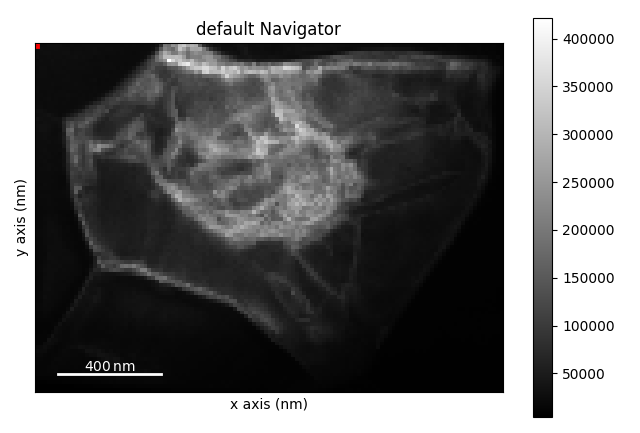

<IPython.core.display.Javascript object>


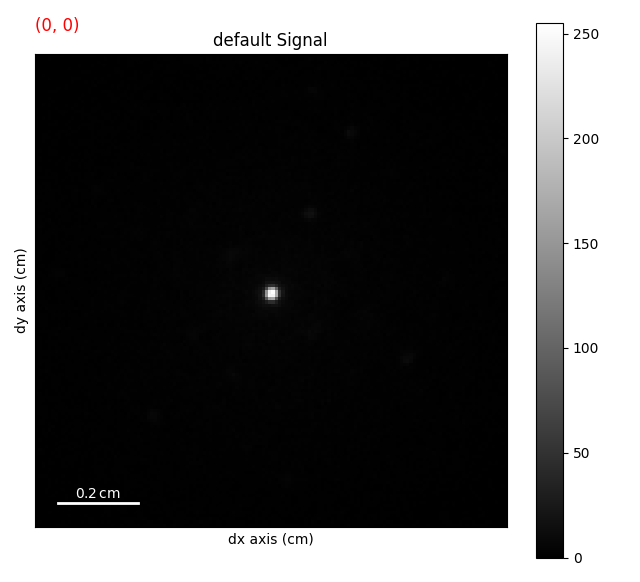

In [8]:
# NBVAL_IGNORE_OUTPUT
lazy_4d.plot()

## Load the underlying Dask array of the HyperSpy lazy signal as a LiberTEM dataset

In [9]:
dask_ds = ctx.load("dask", lazy_4d.data, sig_dims=2)

In [10]:
pick_a = ctx.create_pick_analysis(dataset=dask_ds, y=45, x=60)
pick_res = ctx.run(pick_a)

In [11]:
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

In [12]:
%%timeit
# NBVAL_SKIP
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

894 ms ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


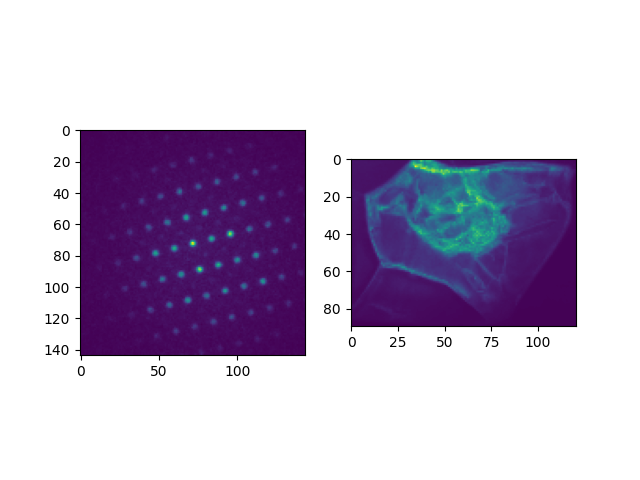

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pick_res['intensity'].raw_data)
axes[1].imshow(sum_res['intensity'].data)

## Load data using LiberTEM

In [14]:
native_ds = ctx.load('auto', path)

In [15]:
sum_res = ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

In [16]:
%%timeit
# NBVAL_SKIP
sum_res = ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

279 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Create dask array from LiberTEM dataset

In [17]:
dask_array, workers = make_dask_array(native_ds)

## Create lazy HyperSpy signal from Dask array

In [18]:
libertem_4d = pyxem.signals.LazyDiffraction2D(dask_array)

[########################################] | 100% Completed |  0.4s


<IPython.core.display.Javascript object>


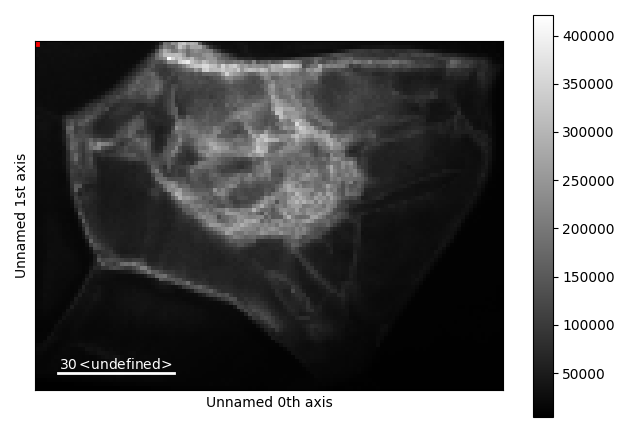

<IPython.core.display.Javascript object>


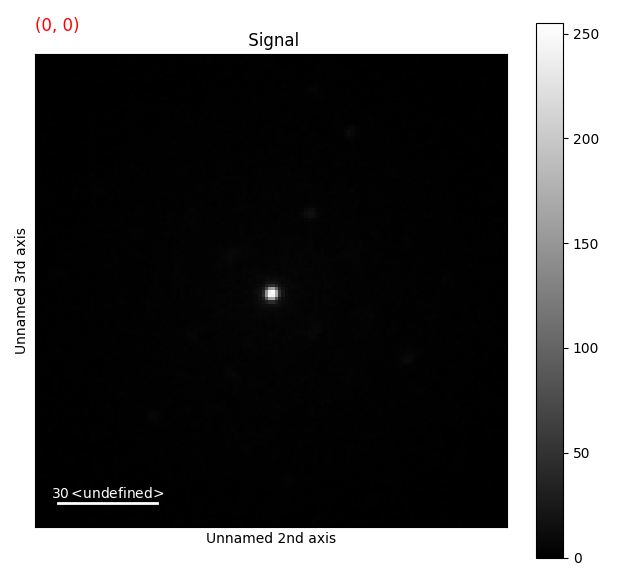

In [19]:
# NBVAL_IGNORE_OUTPUT
libertem_4d.plot()

## Create HyperSpy signal from LiberTEM computation

As an example, this uses the LiberTEM blobfinder https://libertem.github.io/LiberTEM-blobfinder/

In [20]:
# Context that uses the DelayedJobExecutor to calculate results as lazy Dask arrays
delayed_ctx = Context(executor=DelayedJobExecutor())

In [21]:
reference_frame = lazy_4d.data[50, 60].compute()

In [22]:
zero = (71, 71)
r = 1.5
pattern = patterns.BackgroundSubtraction(radius=r)

In [23]:
peaks = correlation.get_peaks(sum_result=reference_frame, match_pattern=pattern, num_peaks=50)

In [24]:
matcher = fm.FullMatcher()

In [25]:
all_match = matcher.full_match(peaks, zero=zero)

In [26]:
match = all_match[0][0]

<IPython.core.display.Javascript object>


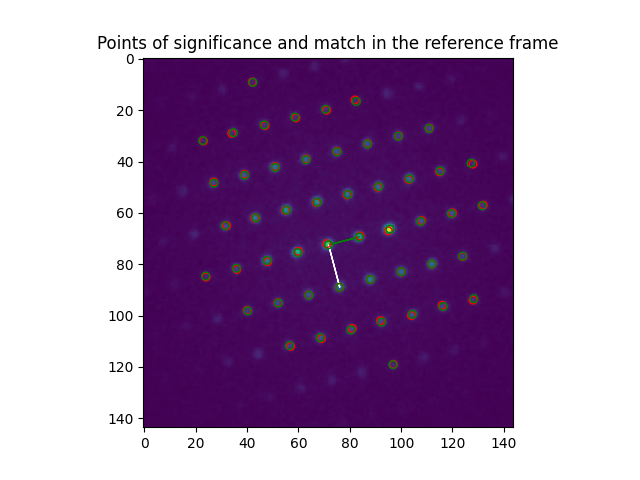

In [27]:
fig, axes = plt.subplots()
axes.imshow(reference_frame)
plt.title("Points of significance and match in the reference frame")

for p in np.flip(match.refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="r", fill=False))
for p in np.flip(match.calculated_refineds, axis=1):
    axes.add_artist(plt.Circle(p, r, color="g", fill=False))
plt.arrow(*np.flip(match.zero), *(np.flip(match.a)), color='g')
plt.arrow(*np.flip(match.zero), *(np.flip(match.b)), color='w')

### Per-frame refinement of the parameters we found above

In [28]:
%%time
# Note how the function call takes only miliseconds since it
# just builds the task tree. The actual computation
# happens only at the end.
(refined, indices) = refinement.run_refine(
    # Use DelayedJobExecutor
    ctx=delayed_ctx,
    # One could also use a dataset created from a HyperSpy signal here
    dataset=native_ds,
    zero=match.zero,
    a=match.a,
    b=match.b,
    matcher=matcher,
    match_pattern=pattern,
    indices=np.mgrid[-4:5, -4:5],
)
# NBVAL_IGNORE_OUTPUT

CPU times: user 227 ms, sys: 16.6 ms, total: 244 ms
Wall time: 242 ms


In [29]:
# Some lazy downstream calculations with the result arrays
abs_a = np.sqrt(np.sum(refined['a'].delayed_data**2, axis=-1))
abs_b = np.sqrt(np.sum(refined['b'].delayed_data**2, axis=-1))

In [30]:
# Create and plot HyperSpy signal from the Dask arrays
ratio = hs.signals.Signal2D(abs_a / abs_b)

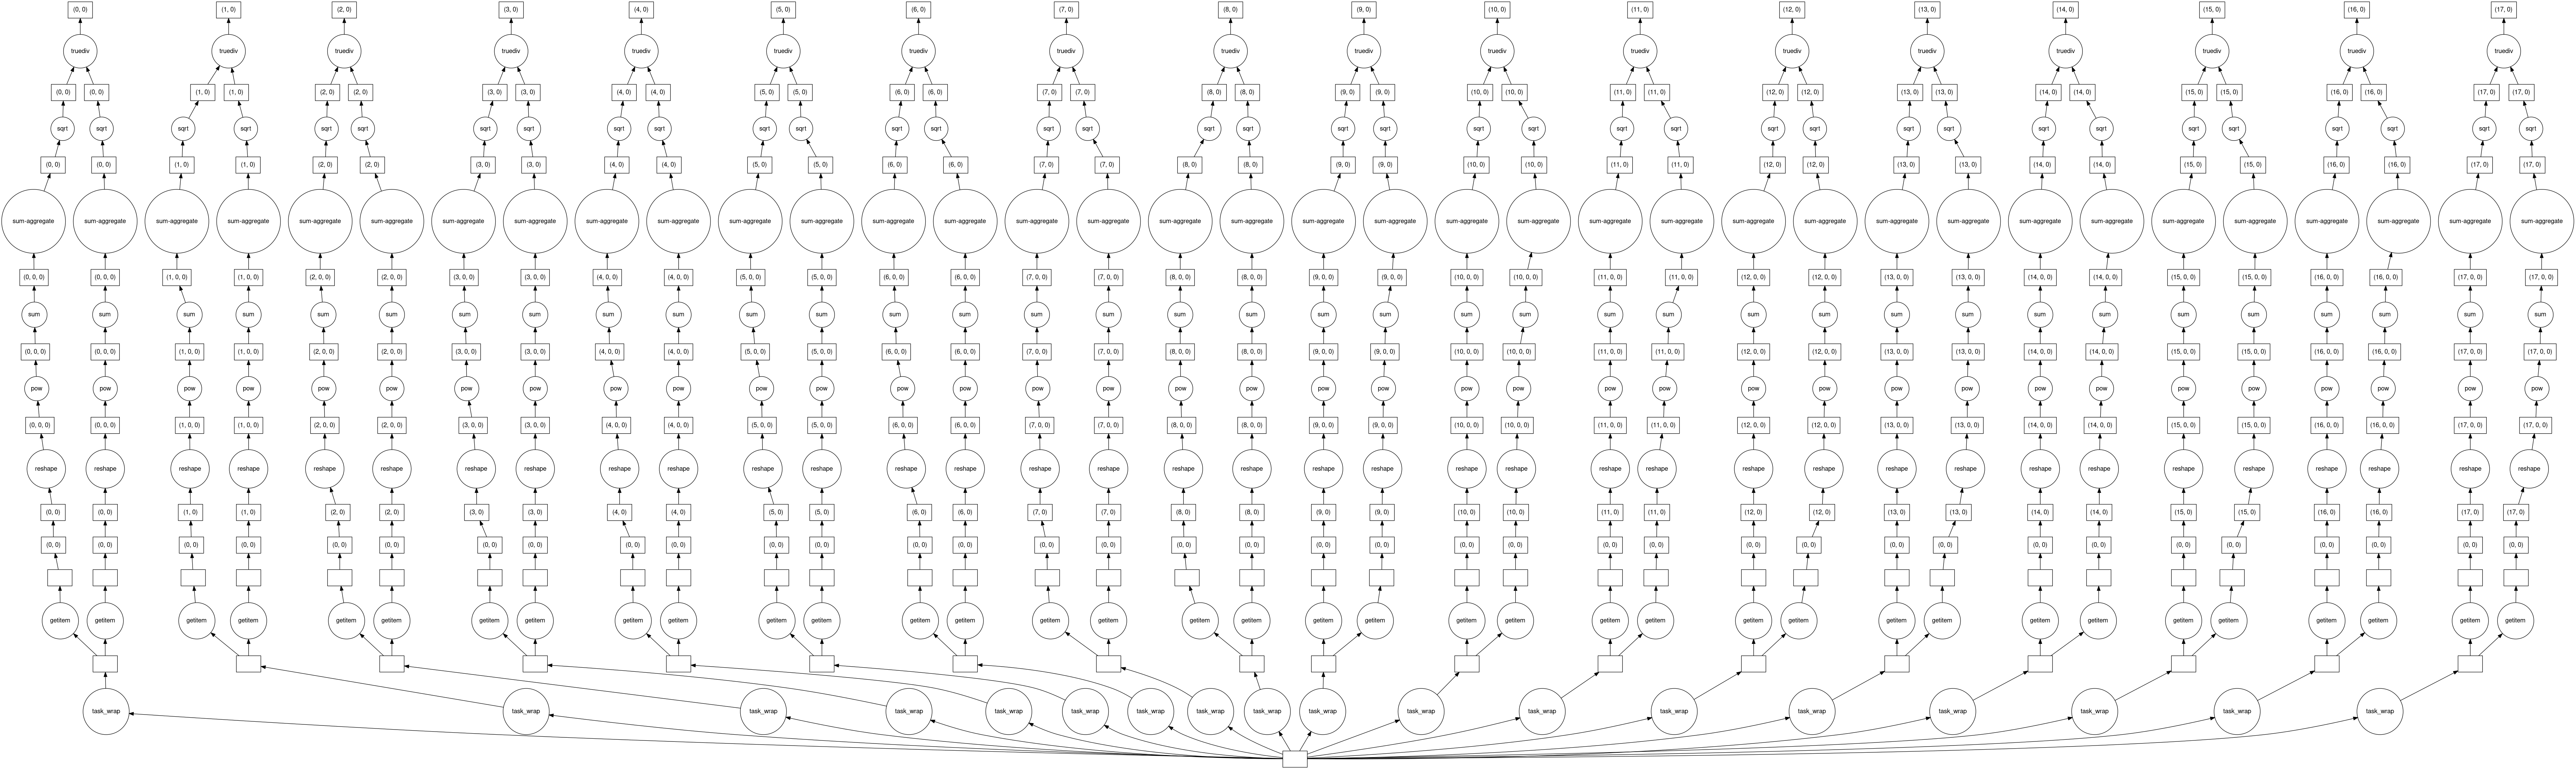

In [31]:
ratio.data.visualize()

<IPython.core.display.Javascript object>


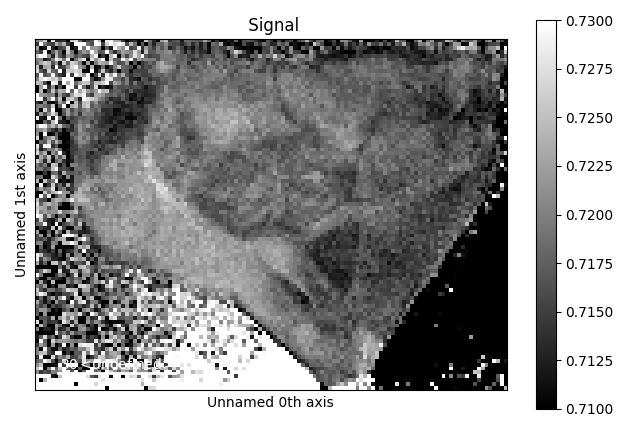

CPU times: user 29.4 s, sys: 7.84 s, total: 37.2 s
Wall time: 26.2 s


In [32]:
# Plotting triggers the computation
%time ratio.plot(vmin=0.71, vmax=0.73)
# NBVAL_IGNORE_OUTPUT